In [124]:
import pandas as pd
import hashlib
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree

from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from IPython.display import HTML
style = "<style>svg{width: 70% !important; height: 60% !important;} </style>"
HTML(style)

### Обезличивание и загрузка данных

In [89]:
# Define a custom date parsing function
def parse_datetime(date_string):
    return pd.to_datetime(date_string, format='%d.%m.%Y %H:%M:%S')

In [90]:
%%time
df = pd.read_excel('ИсходныеДанные.xlsx', parse_dates=['ДатаЗаказа', 'ДатаПоследнегоСтатуса'], date_parser=parse_datetime)

# delete na rows
df = df.dropna()

# unfacing mobile phones
# df['user_code'] = df['Телефон'].apply(lambda x: hashlib.md5(str(x).encode()).hexdigest())
# df = df.drop(columns=['Телефон'])

# add delivery days
df['Days_Delivery'] = (df['ДатаПоследнегоСтатуса'] - df['ДатаЗаказа']).dt.days

# cut 15 days from data
df = df[df['ДатаЗаказа'] < (df.ДатаЗаказа.max() - pd.DateOffset(days=15))]

# leave only delivered less than 60 days and less 7 trying
df = df[(df['Days_Delivery'] <= 60) & (df['ПопыткиДоставки'] <= 7)]

# add redeemed
df['redeemed'] = df.Статус == 'Выкуплен'

CPU times: total: 45.9 s
Wall time: 47 s


In [91]:
df

,Номер,ДатаЗаказа,Статус,ПопыткиДоставки,ДатаПоследнегоСтатуса,СуммаДокумента,Подразделение,Days_Delivery,redeemed
0,DL00-037866,2022-01-03 18:21:58,Выкуплен,1.0,2022-01-06 19:31:42,8524.0,Владикавказ,3,True
1,DL00-037878,2022-01-03 18:37:55,Выкуплен,1.0,2022-01-06 10:33:27,6734.0,Казань,2,True
2,DL00-037885,2022-01-03 19:16:34,Выкуплен,1.0,2022-01-06 10:33:28,8524.0,Казань,2,True
3,DL00-037886,2022-01-03 19:16:36,Выкуплен,1.0,2022-01-06 10:33:27,2800.0,Казань,2,True
4,DL00-037942,2022-01-04 12:24:35,Не выкуплен,1.0,2022-01-14 13:13:02,3700.0,Иркутск,10,False
...,...,...,...,...,...,...,...,...,...
332361,DL00-335985,2023-06-11 15:11:56,Не выкуплен,1.0,2023-06-30 13:39:24,5034.0,Краснодар,18,False
332362,DL00-336003,2023-06-11 15:14:05,Выкуплен,1.0,2023-06-12 19:54:37,7300.0,Крым,1,True
332363,DL00-336042,2023-06-11 15:22:49,Выкуплен,1.0,2023-06-12 19:57:48,5500.0,Махачкала,1,True
332364,DL00-336056,2023-06-11 15:23:49,Выкуплен,1.0,2023-06-12 22:52:05,7838.0,Пятигорск,1,True


### Процент успешных доставок по количеству попыток доставки

In [92]:
success_percentage = df.groupby('ПопыткиДоставки')['redeemed'].mean()*100
success_percentage

ПопыткиДоставки
1.0    64.996308
2.0    66.171740
3.0    56.061115
4.0    48.258706
5.0    43.353474
6.0    38.436482
7.0    34.959350
Name: redeemed, dtype: float64

<AxesSubplot: xlabel='Days_Delivery'>

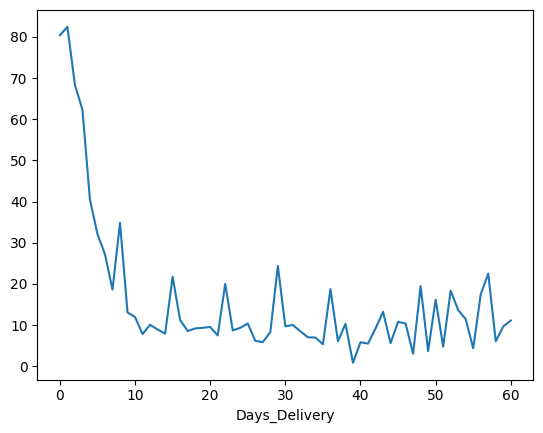

In [120]:
success_percentage.plot()

### Процент успешных доставок по количеству дней доставки

In [94]:
success_percentage = df.groupby('Days_Delivery')['redeemed'].mean()*100
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(success_percentage)

Days_Delivery
0     80.381091
1     82.451543
2     68.331816
3     62.286585
4     40.460310
5     32.114768
6     27.180952
7     18.614884
8     34.853831
9     13.087745
10    11.969904
11     7.825831
12    10.080183
13     8.923997
14     7.928731
15    21.731959
16    11.235955
17     8.557951
18     9.187859
19     9.335900
20     9.538462
21     7.494407
22    20.021645
23     8.708709
24     9.333333
25    10.371820
26     6.172840
27     5.854801
28     8.292683
29    24.349882
30     9.705882
31    10.032362
32     8.487085
33     7.037037
34     6.976744
35     5.339806
36    18.750000
37     6.081081
38    10.303030
39     0.847458
40     5.833333
41     5.511811
42     9.166667
43    13.223140
44     5.617978
45    10.769231
46    10.389610
47     3.030303
48    19.444444
49     3.703704
50    16.176471
51     4.761905
52    18.367347
53    13.636364
54    11.428571
55     4.347826
56    17.500000
57    22.500000
58     6.060606
59     9.677419
60    11.111111
Name: rede

<AxesSubplot: xlabel='Days_Delivery'>

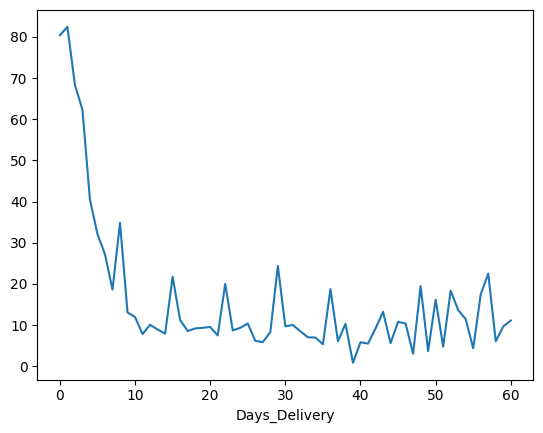

In [121]:
success_percentage.plot()

### Дерево решений

In [129]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
clf

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [130]:
X = df[['ПопыткиДоставки', 'Days_Delivery']]
y = df.redeemed

In [131]:
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

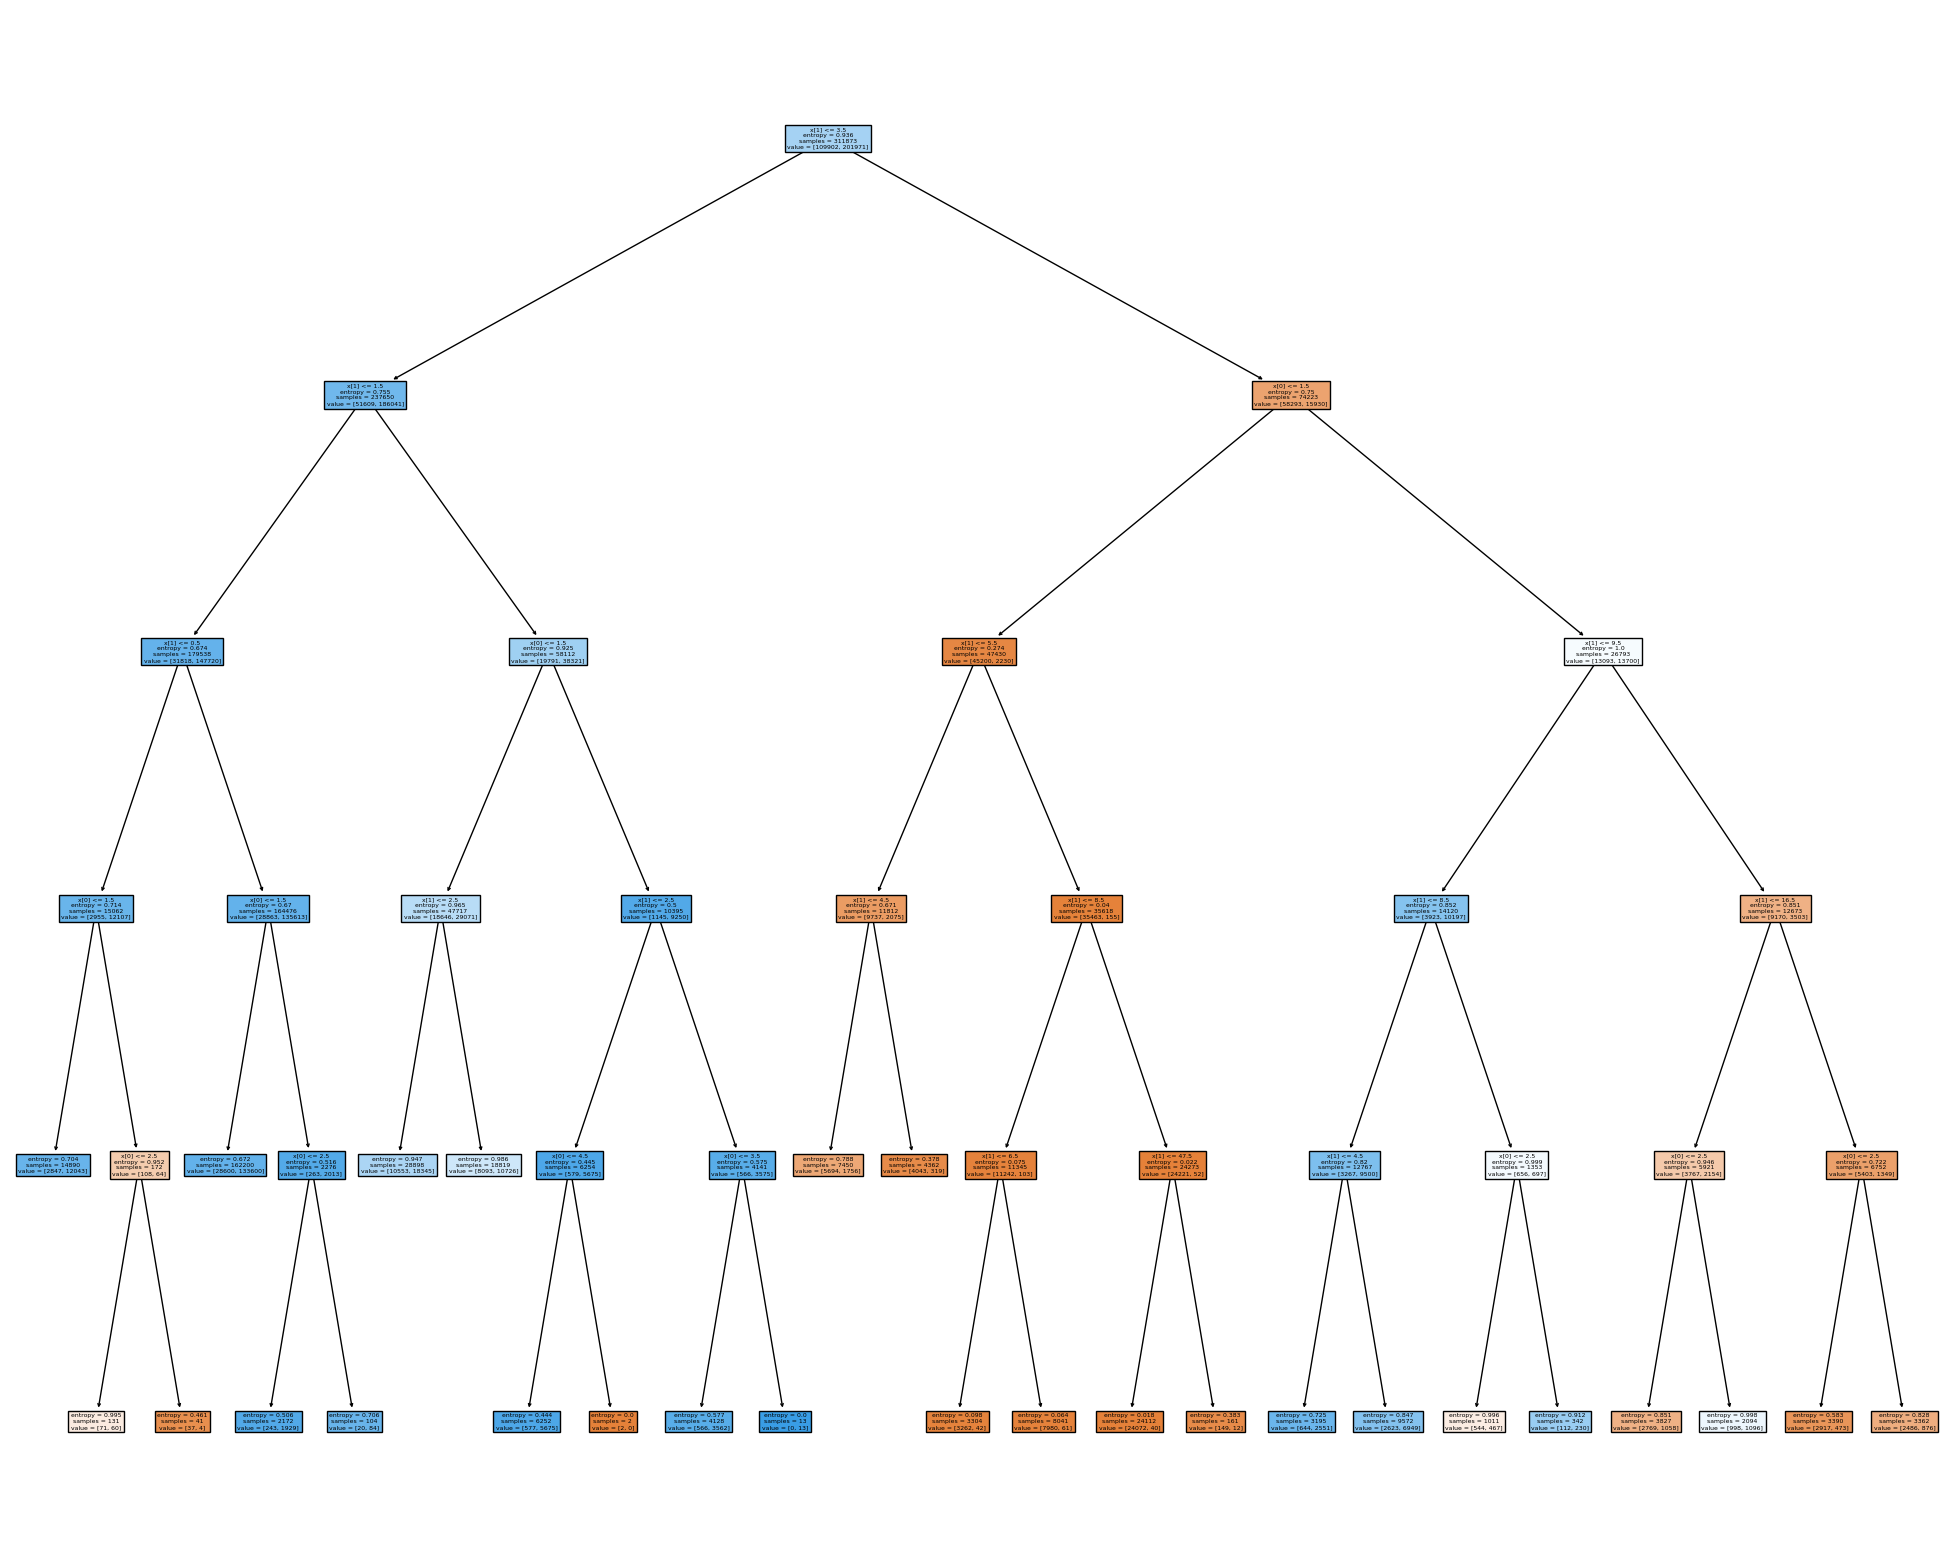

In [132]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, filled=True)